# Simulating the Kalman Filter by a RNN


In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import local libraries
from src.OptimalControl.KalmanFilter import KalmanFilter
from environments.linear import Linear_SDI


### Initialization

Text(0, 0.5, '$\\dot{x}$')

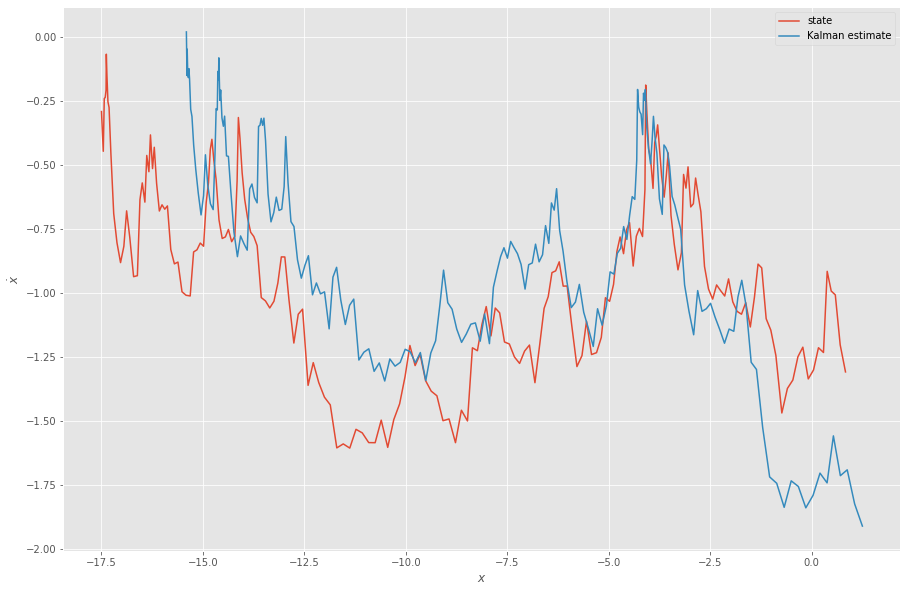

In [7]:
key = jrandom.PRNGKey(0)
N = 200

env = Linear_SDI(end_time=20)
KF = KalmanFilter(env.A, env.B, env.C, env.w, env.v)

X = np.zeros((N, 2))
Y = np.zeros((N, 2))
Xest = np.zeros((N, 2))

x_est = env.reset()
for it in range(N):
    control = jrandom.normal(key, (1,))
    obs, rew, done, _ = env.step(control)

    x_est += KF(x_est, control, obs)*env.dt

    # save
    X[it] = env.state
    Y[it] = obs
    Xest[it] = x_est

    # step
    key, subkey = jrandom.split(key)
    if done:
        x_est = env.reset()

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(X[:,0], X[:,1], label='state')
#ax.plot(Y[:,0], Y[:,1], label='observation')
ax.plot(Xest[:,0], Xest[:,1], label='Kalman estimate')
ax.legend()
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\dot{x}$')